In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *
import plotly.graph_objects as go


import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                    #  'figure.figsize': [14,6],
                     })


from pida_functions import *

In [2]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    return df
    
# df = loaddata("data/pida_new_full.root", entry_stop=None, forceit=False)
df = pl.scan_parquet("data/pida_new_full.parquet")
# df = pl.scan_parquet('data/pida_new.parquet')
# df = pl.scan_parquet('data/pida_new.parquet')


In [3]:
dftrkg4 = getbestof(df)

In [4]:
dfall = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 12
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity_planes_B')*pl.col('trkcompleteness_planes_B'),
)


In [5]:
dftmp:pl.DataFrame
if isinstance(dfall, pl.LazyFrame):
    dftmp = dfall.group_by(selection_events(), maintain_order=True).agg(
    ).collect()
    # dftmp = dftmp.head(int(len(dftmp)*0.1))
    # dftmp = dftmp
    # dfall = dfall.join(dftmp.lazy(), on=selection_events()).collect()
    if isinstance(dfall, pl.LazyFrame):
        dfall = dfall.collect()

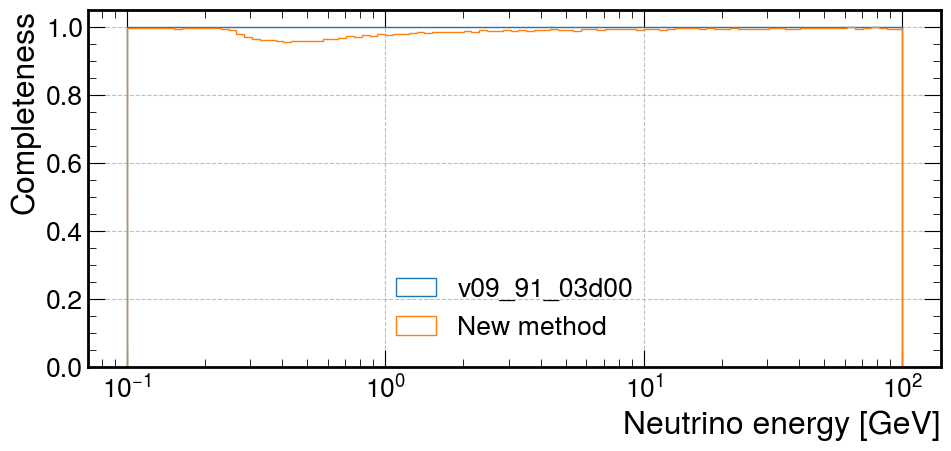

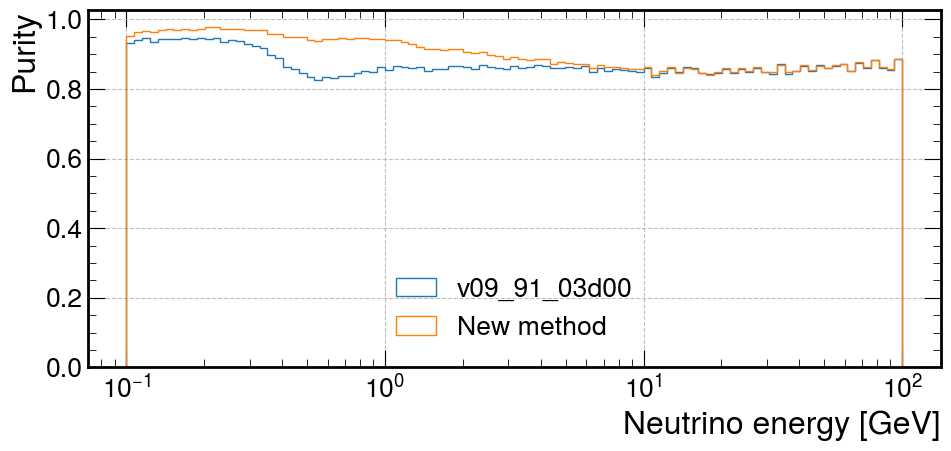

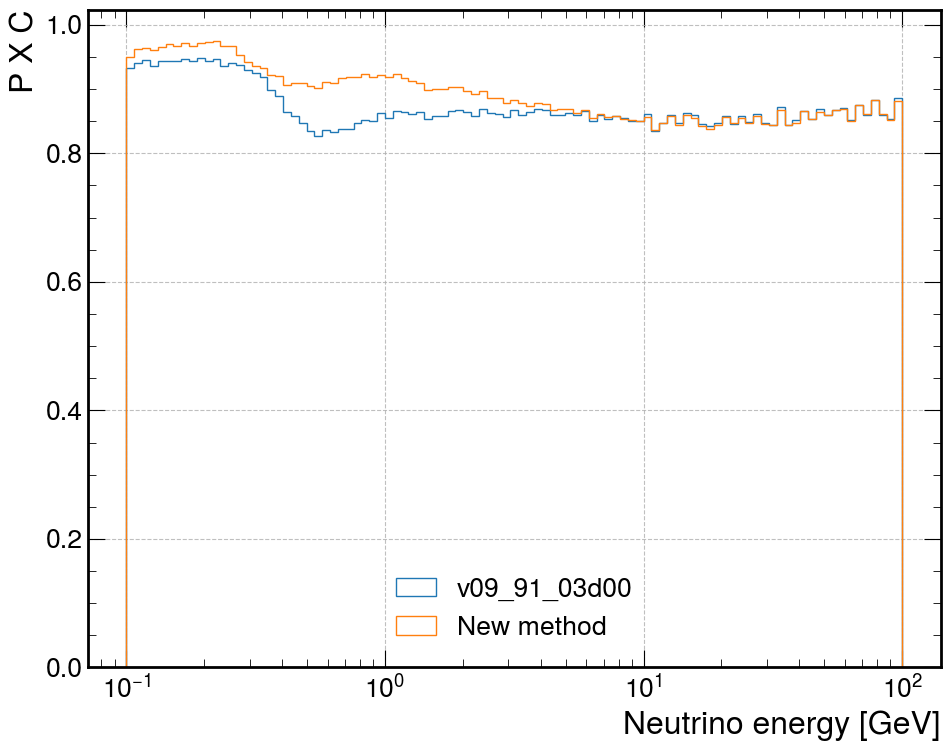

In [6]:
def plot_purity_completeness(df:pl.DataFrame,
                             dfall:pl.DataFrame,
                             type="purity",
                             binse=None,
                             label=None,
                             plotnevents=False,
                             filter:callable = None,
                             plane="B",
                             ):
    
    dffiltered = df.filter(
        filter(plane),
    )
    if not binse:
        binse = np.logspace(-1,2, 100)
    bnall, b = np.histogram(dfall['enu_truth'], bins=binse)
    bn, b = np.histogram(df['enu_truth'], bins=binse)
    bnfiltered, b = np.histogram(dffiltered['enu_truth'], bins=binse)
    # plt.hist(b[:-1], b, weights=bn, histtype='step');

    completeness = np.divide(bn, bnall, out=np.zeros_like(bnall, dtype=np.float64), where=bnall!=0)
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    if type=="completeness":
        val = completeness
    elif type=="purity":
        val = purity
    else:# type=="cnp":
        type = "P x C"
        val = purity*completeness

    plt.hist(b[:-1], b, weights=val, histtype='step', label=label);
    plt.ylabel(type.title())
    plt.xlabel('Neutrino energy [GeV]')
    plt.legend()
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bnall, alpha=0.2, log=False)
        ax2.set_ylabel(rf'# of  events')
        ax2.set_yscale('log')
        ax2.grid(False)
    plt.sca(ax)
    return val, b

def print_ratio(a, b):
    try:
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
    except Exception as error:
        # print(error)
        a=len(a.group_by(selection_events()).agg())
        b=len(b.group_by(selection_events()).agg())
        print(a, b, np.divide(a,b, out=np.zeros_like(b, dtype=np.float64), where=b!=0))
def plot_ratio(data, bins, var='enu_truth', general_filter=None, thefilter=None, plotnevents=False):
    if general_filter is not None:
        data = general_filter(data)
    if thefilter is None:
        def thefilter(df):
            return df.filter(ismu())
    data_filtered = thefilter(data)
    bt, b = np.histogram(data[var], bins=bins)
    bm, b = np.histogram(data_filtered[var], bins=bins)
    bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
    # print(sum(bm),sum(bt))
    plt.hist(b[:-1], b, weights=bratio, histtype='step')
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bt, alpha=0.2, log=False)
        # ax2.hist(b[:-1], b, weights=bm, alpha=0.2, log=False)
        ax2.set_ylabel(rf'# of events')
        ax2.grid(False)
    plt.sca(ax)

dfall = dfall.with_columns(
    (
        ( (pl.col('trkstartx')- pl.col('recovtxx'))**2 + 
           (pl.col('trkstarty')- pl.col('recovtxy'))**2 + 
           (pl.col('trkstartz')- pl.col('recovtxz'))**2 
        ).sqrt()
    ).alias('distvtx'),
)
    
dfallnue = dfall.group_by(selection_events()).agg(
    pl.all().last()
)
df_e = dfall.sort(trkcalo("W")).group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)

# df_e = create_ecandidate(dfall, filter_protons=False, return_only_selected=True)
df_e_B = create_ecandidate(dfall, return_only_selected=True)

labelold="v09_91_03d00"
labelnew="New method"
thefilter = ise
plt.figure(figsize=(10,5))
plot_purity_completeness(df_e, dfallnue, "completeness", filter=thefilter, label=labelold);
plot_purity_completeness(df_e_B, dfallnue, "completeness", filter=thefilter, label=labelnew);
plt.xscale('log')
plt.figure(figsize=(10,5))
plot_purity_completeness(df_e, dfallnue, "purity", filter=thefilter, label=labelold);
plot_purity_completeness(df_e_B, dfallnue, "purity", filter=thefilter, label=labelnew);
plt.xscale('log')
plt.figure(figsize=(10,8))
plot_purity_completeness(df_e, dfallnue, "pnc", filter=thefilter, label=labelold);
plot_purity_completeness(df_e_B, dfallnue, "pnc", filter=thefilter, label=labelnew);
plt.xscale('log')

In [7]:
fig = plt.figure()
size = fig.get_size_inches()*fig.dpi # size in pixels
fig.get_size_inches()


array([10., 10.])

<Figure size 1000x1000 with 0 Axes>

In [8]:
print(df_e_B.filter( ~ise()).group_by(pl.col('trkg4pdg_planes_B')).agg( pl.len()).sort('len'))

df_e.filter(
    isparticle(22)
).sort(selection_events())


shape: (31, 2)
┌───────────────────┬───────┐
│ trkg4pdg_planes_B ┆ len   │
│ ---               ┆ ---   │
│ i32               ┆ u32   │
╞═══════════════════╪═══════╡
│ 1000160350        ┆ 1     │
│ 1000150330        ┆ 1     │
│ 1000160320        ┆ 1     │
│ 1000190400        ┆ 1     │
│ 1000180380        ┆ 1     │
│ …                 ┆ …     │
│ -1                ┆ 121   │
│ -211              ┆ 1640  │
│ 211               ┆ 2951  │
│ 2212              ┆ 8892  │
│ 22                ┆ 26870 │
└───────────────────┴───────┘


run,subrun,event,nuPDG_truth,ccnc_truth,mode_truth,nuWeight_truth,enu_truth,vtxx_truth,vtxy_truth,vtxz_truth,recovtxx,recovtxy,recovtxz,lepen,lepmass,leppdg,lepid,ntracks,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4mother,trknhits,trkg4id_planes_U,trkg4id_planes_V,trkg4id_planes_W,…,allcalo_planes_U,allcalo_planes_V,allcalo_planes_W,nallhits_planes_U,nallhits_planes_V,nallhits_planes_W,otherallcalo_planes_U,otherallcalo_planes_V,otherallcalo_planes_W,othernallhits_planes_U,othernallhits_planes_V,othernallhits_planes_W,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4mother_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trktotalen_planes_B,trkpartialen_planes_B,trkpidchi2ndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidndf_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B,otherallcalo_planes_B,othernallhits_planes_B,pnc,distvtx
i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,i32,i32,i32,i32,i32,…,f32,f32,f32,i32,i32,i32,f32,f32,f32,i32,i32,i32,i32,i32,f32,f32,i32,f32,f32,i32,i32,f32,f32,f32,i32,f32,f32,f32,f32,i32,f32,f32,i32,f32,i32,f32,f32
1453,1,208,12,0,0,2.2157376e7,0.134363,-226.433548,-565.895386,1325.989014,-226.49295,-565.944824,1325.315674,0.07617,0.000511,11,5,2,1,-226.370758,-565.074829,1325.901123,-231.319611,-563.829651,1327.350098,0.6875,1.0,1,22,0.004758,0.0,0,16,1,1,1,…,0.072916,0.066184,0.0872,55,48,35,0.047552,0.044042,0.05695,38,34,25,1,22,0.004758,0.0,0,0.571429,1.0,7,4,0.014347,18.49357,18.49357,5,245.773758,150.368332,47.643372,28.695936,5,0.916544,0.072916,48,0.047552,38,0.571429,1.055734
1497,1,450,12,0,2,1.2694247e7,48.378712,224.276031,205.317352,103.81649,224.512283,204.977615,103.60463,1.468363,0.000511,11,4,17,0,231.975845,204.747635,105.912453,339.328552,-120.88868,91.651627,0.110603,0.979224,20847,22,5.564062,6.1035e-8,8,16193,20847,20847,1,…,20.11302,20.472498,30.073414,7593,7919,4290,0.910011,0.589371,14.655952,597,573,484,20847,22,5.564062,6.1035e-8,8,0.117586,0.987516,6727,791,18.553701,1.122827e7,2.17913,2,215.369049,150.833511,37.187931,21.559008,2,5.626651,20.472498,7919,0.910011,597,0.116118,7.815606
1497,1,530,12,0,2,3.8682548e7,4.234991,-305.138184,50.248405,1112.578369,-305.026581,50.220894,1112.799805,1.096075,0.000511,11,4,2,0,-305.703064,50.113636,1113.012207,-211.780396,287.779236,1137.205933,0.397947,0.903918,4,22,1.440626,0.0,3,2435,4,4,4,…,2.656314,2.975482,3.574492,1352,1417,758,0.186223,0.127882,0.149055,164,135,122,4,22,1.440626,0.0,3,0.355787,0.921376,1054,375,2.228645,3515.097168,2.862079,2,245.185394,94.376152,19.323648,10.241055,2,5.13417,2.975482,1352,0.186223,164,0.327814,0.717111
1497,1,554,12,0,10,3.3864504e7,6.12711,-246.51445,606.915466,133.3871,-189.684937,536.439209,293.969543,5.559672,0.000511,11,4,1,0,-189.770752,536.53009,293.626648,-189.767944,537.341614,294.192352,1.0,0.777778,103,22,0.00633,0.0,14,7,103,103,-1,…,0.013277,0.012369,0.014601,15,15,12,0.008758,0.007116,0.014601,12,11,12,103,22,0.00633,0.0,14,1.0,1.0,4,4,0.005253,0.0,0.0,1,181.027344,79.062424,12.781417,5.80204,-1,4.163769,0.012369,15,0.014601,12,1.0,0.364967
1497,1,11751,12,0,1,4.884688e7,3.469189,326.500702,484.319366,553.749817,326.118774,484.233948,553.554382,0.449756,0.000511,11,4,6,0,334.780762,490.228973,546.284485,362.028625,499.531677,531.076416,0.514523,0.932331,787,22,0.183733,0.0,703,241,787,787,787,…,0.717851,0.505899,0.782425,364,258,267,0.099387,0.058224,0.074986,107,75,68,787,22,0.183733,0.0,703,0.526786,0.967213,112,59,0.174773,148.466507,19.475964,70,512.504089,141.258362,29.48876,20.64917,84,5.360116,0.717851,364,0.099387,107,0.509514,12.799288
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
74517882,1,4484

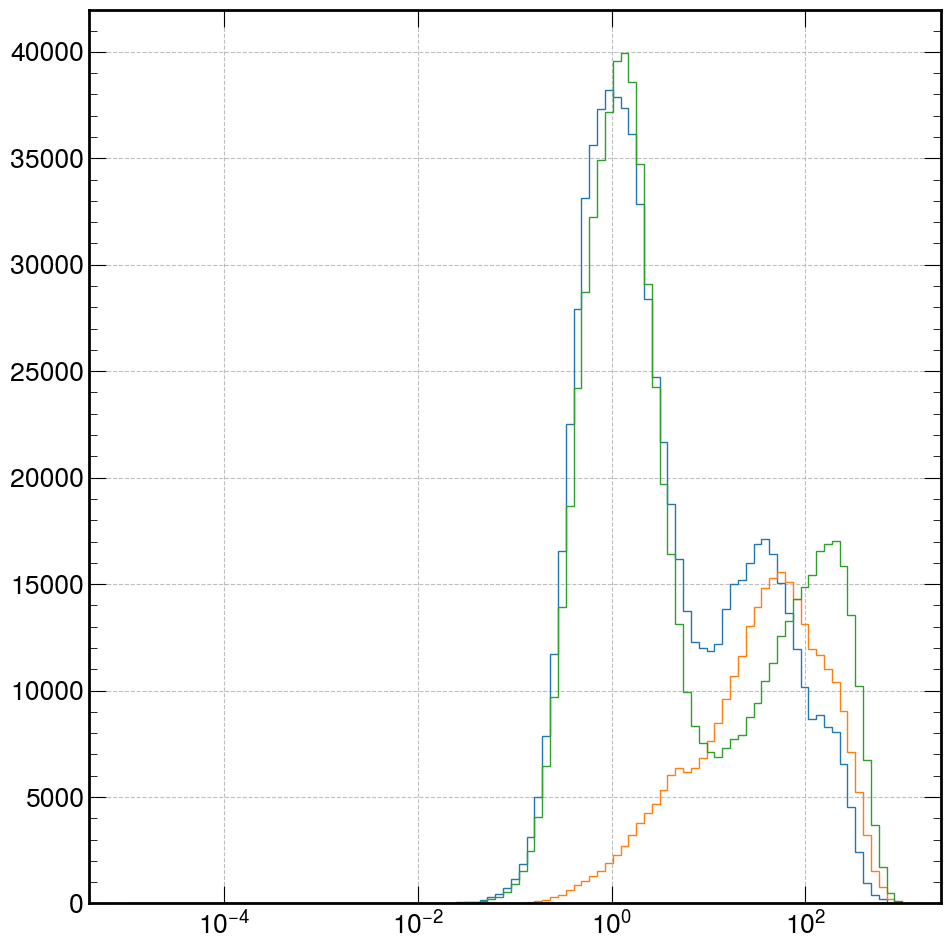

In [9]:
df_e_B = create_ecandidate(dfall)
    
dftest = df_e_B.with_columns(
    pl.col('distvtx')
)

binsreldist=np.logspace(-5, 3, 100)
plt.hist(dftest.filter( ise())['distvtx'], bins=binsreldist, histtype='step');
plt.hist(dftest.filter(~ise(), isparticle(22))['distvtx'], bins=binsreldist, histtype='step');
plt.hist(dftest.filter(~ise(),~isparticle(22))['distvtx'], bins=binsreldist, histtype='step');
plt.xscale('log')

714439 1124846 0.635143833022476


<Figure size 1000x1000 with 0 Axes>

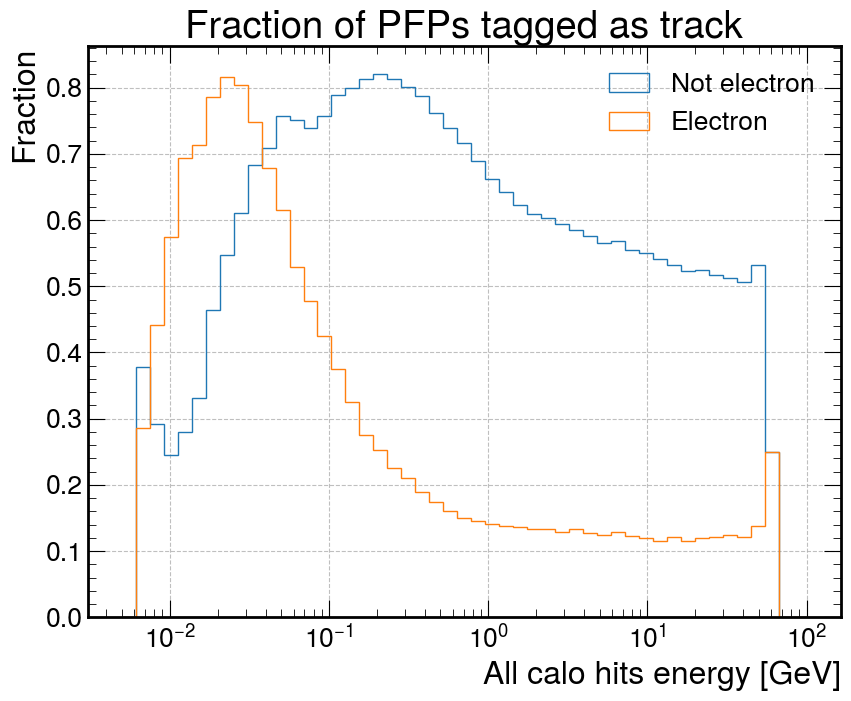

In [10]:
dftest = create_ecandidate(dfall, clear_low_en_as_shower=False, filter_protons=False)
plt.figure()
plt.figure(figsize=(9,7.5))
binse = np.logspace(np.log10(5e-3),2,50)
bt, b = np.histogram(dftest.filter(~ise(),True)['allcalo_planes_B'], bins=binse)
bm, b = np.histogram(dftest.filter(~ise(), ~isShower())['allcalo_planes_B'], bins=binse)
bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
plt.hist(b[:-1], b, weights=bratio, histtype='step', label='Not electron')
bt, b = np.histogram(dftest.filter(ise(),True)['allcalo_planes_B'], bins=binse)
bm, b = np.histogram(dftest.filter(ise(), ~isShower())['allcalo_planes_B'], bins=binse)
bratio = np.divide(bm, bt, out=np.zeros_like(bt, dtype=np.float64), where=bt!=0)
plt.hist(b[:-1], b, weights=bratio, histtype='step', label='Electron')
# plt.ylim(0,0.03)
plt.xscale('log')
plt.xlabel('All calo hits energy [GeV]')
plt.ylabel('Fraction')
plt.title('Fraction of PFPs tagged as track')
plt.legend()

print_ratio(len(dftest.filter(~ise(), ~isShower())), len(dftest.filter(~ise())))


Text(0.5, 1.0, 'PFPs with biggest charge')

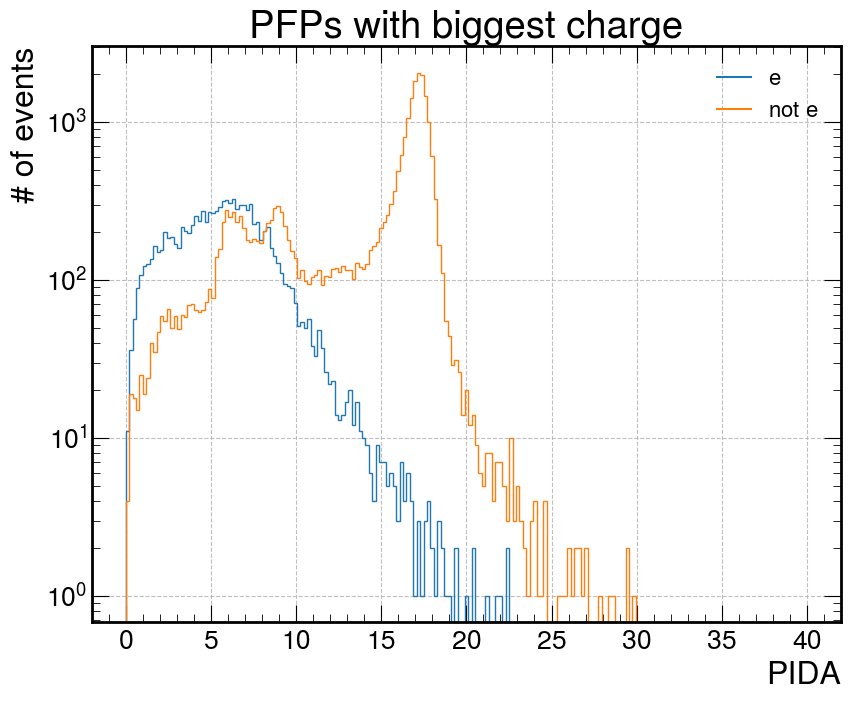

In [11]:

plt.figure(figsize=(9,7.5))
plot_pid(dftest.filter(pl.col('selected_e')), pdg=11, onlyselected=False, ShowersAndTracks=False, onlyShower=False, onlycontained=False)
plot_pid(dftest.filter(pl.col('selected_e')), pdg=11, notthispdg=True, onlyselected=False, ShowersAndTracks=False, onlyShower=False, onlycontained=False)
plt.ylabel('# of events')
plt.xlabel("PIDA")
plt.yscale('log')
plt.title('PFPs with biggest charge')

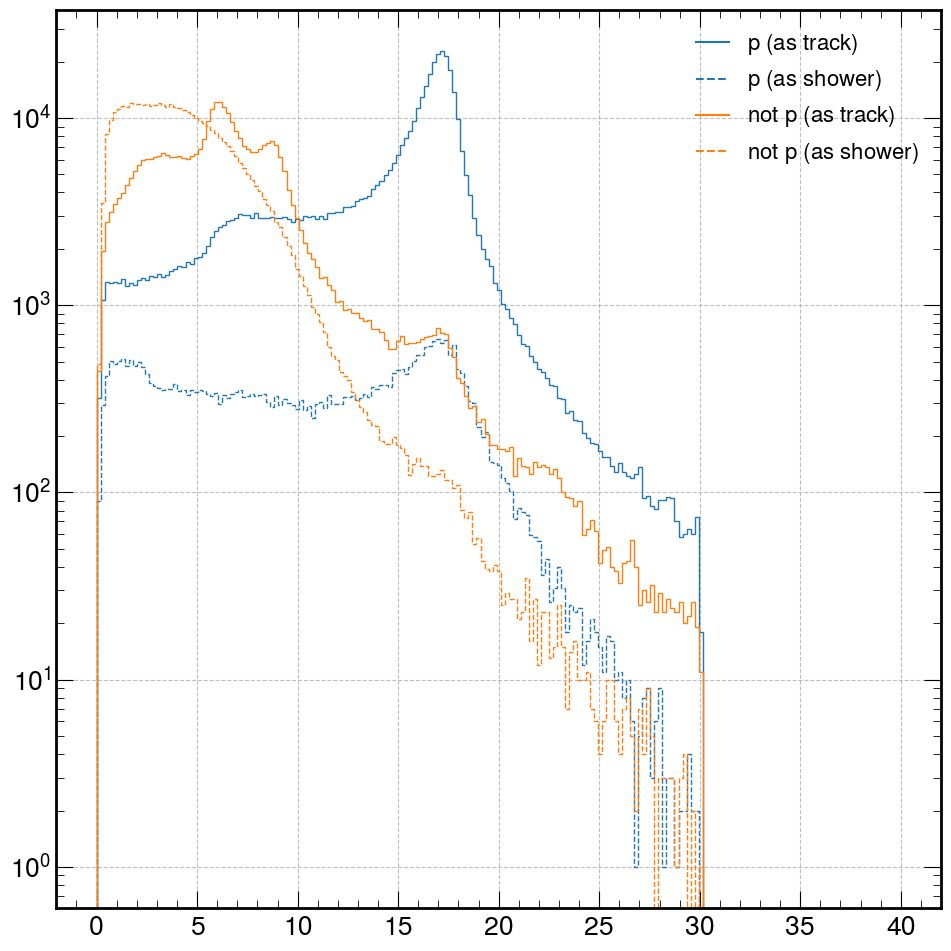

In [12]:
dftest = create_ecandidate(dfall)

dftest = dftest.filter(
    ~pl.col('selected_e')
)

pnccut = 0.
onlycontained=False
plot_pid(dftest, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)')
plot_pid(dftest, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftest, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftest, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
plt.yscale('log')


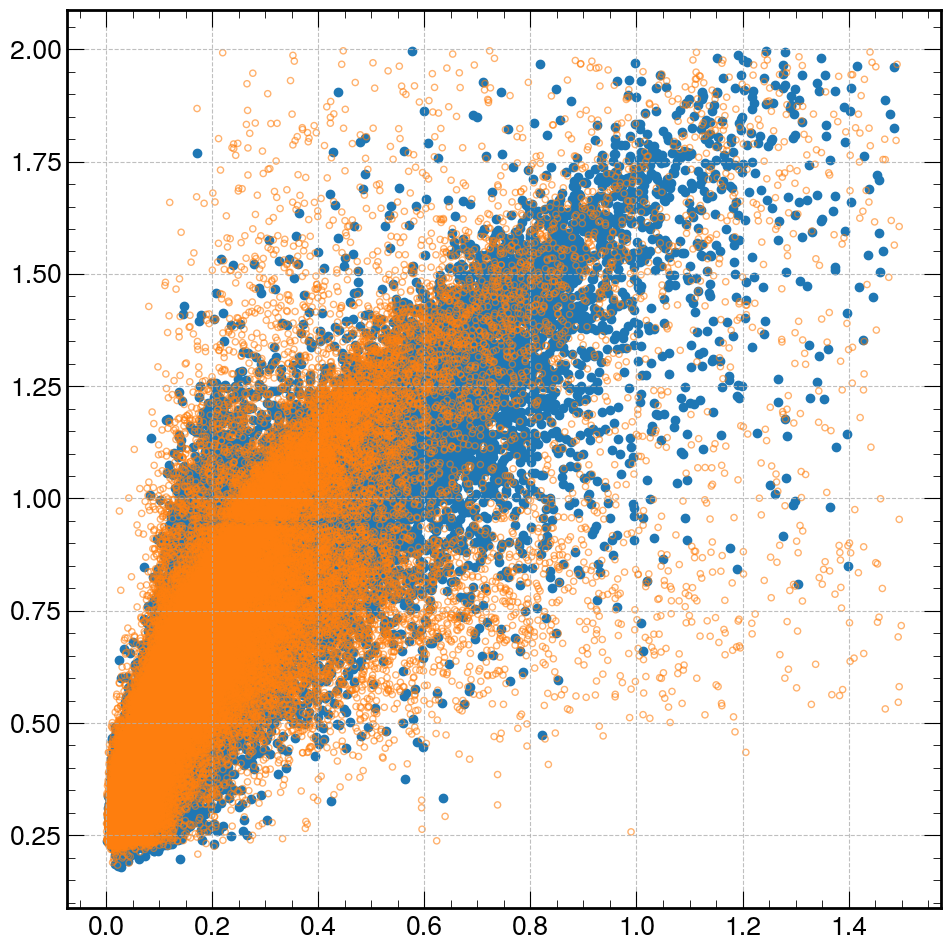

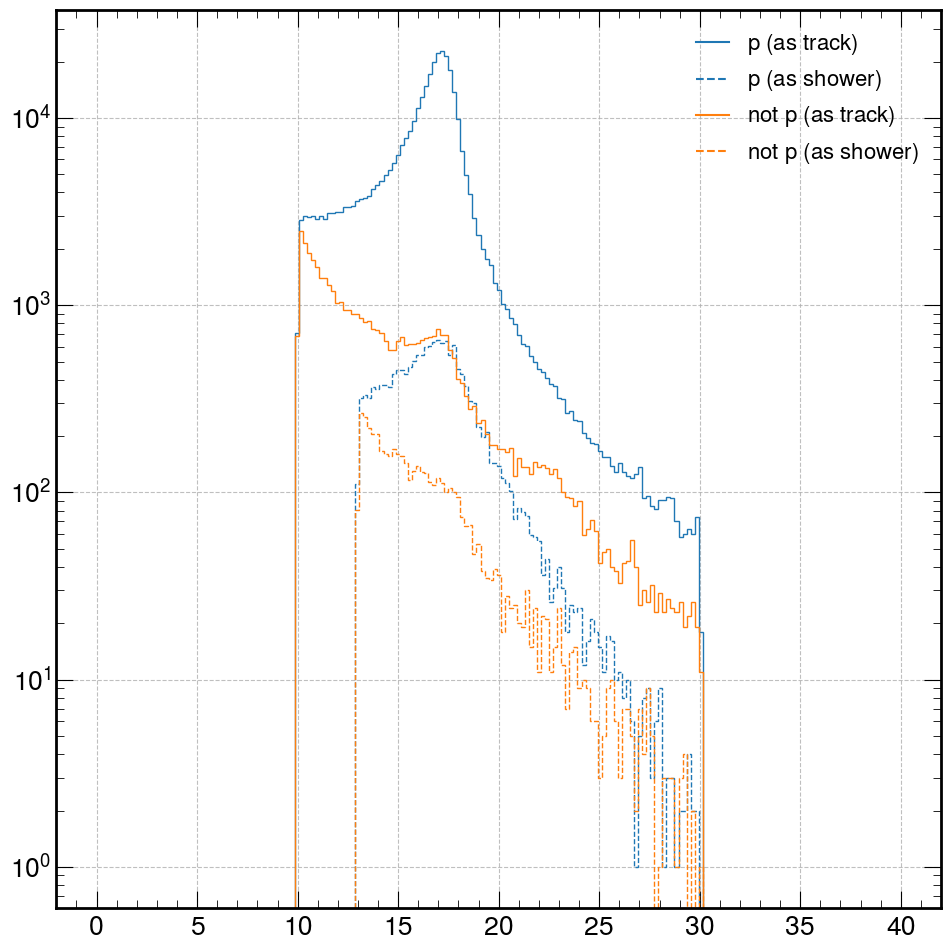

In [13]:
vy='trkmomrange_pr'
vx='trkcalo_planes_B'
binscalo = np.linspace(-0.1,0.5,200)
binsmomrange = np.linspace(0.2, 1, 100)
plt.figure()
dftestpr = create_proton_candidate(dftest, return_only_selected=True)
plt.scatter(dftestpr.filter(isproton()) [vx], dftestpr.filter(isproton())[vy])
plt.scatter(dftestpr.filter(~isproton())[vx], dftestpr.filter(~isproton())[vy], alpha=0.6, s=20, color="C1", facecolor='none')
# plt.xlim(0, 3)
# plt.ylim(0, 3)

plt.figure()
pnccut = 0.
onlycontained=False
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)')
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', ls='--', color='C0')
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=2212, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftestpr, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=2212, label=' (as shower)', notthispdg=True, ls="--", color="C1")
plt.yscale('log')

In [14]:
def plot_purity_completeness_particle(df:pl.DataFrame,
                             type="purity",
                             binse=None,
                             label=None,
                             plotnevents=False,
                             minPnC = 0.8,
                             pdg=2212,
                             selection="selected_pr",
                             donotplot=False,
                             ):
    
    if minPnC == 0: 
        minPnC = -1e12
    df = df.filter(pl.col('pnc')>=minPnC)
    # find all existing protons...
    dfallpr = df.filter(isparticle(pdg), pl.col('pnc')>=minPnC)
    # dfallpr_unique = dfallpr.group_by(selection_events('trkg4id_planes_B')).agg(pl.len(), pl.all().last()).filter(pl.col('len')>=2)
    # print(len(dfallpr_unique), len(dfallpr), len(dfallpr_unique)/len(dfallpr))
    if not binse:
        binse = np.logspace(-1,2, 100)
    bnall, b = np.histogram(dfallpr['enu_truth'], bins=binse)
    bn, b = np.histogram(df.filter(pl.col(selection))['enu_truth'], bins=binse)

    bnfiltered, b = np.histogram(df.filter(pl.col(selection), isparticle(pdg))['enu_truth'], bins=binse)

    completeness = np.divide(bnfiltered, bnall, out=np.zeros_like(bnall, dtype=np.float64), where=bnall!=0)
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    if type=="completeness":
        type='efficiency'
        val = completeness
    elif type=="purity":
        val = purity
    else:# type=="cnp":
        type = "P x C"
        val = purity*completeness

    if donotplot:
        return val, b
    plt.hist(b[:-1], b, weights=val, histtype='step', label=label);
    plt.ylabel(type.title())
    plt.xlabel('Neutrino energy [GeV]')
    plt.legend()
    ax = plt.gca()
    if plotnevents:
        ax2 = plt.twinx()

        ax2.hist(b[:-1], b, weights=bnall, alpha=0.2, log=False)
        ax2.set_ylabel(rf'# of  events')
        ax2.set_yscale('log')
        ax2.grid(False)
    plt.sca(ax)
    return val, b

<Figure size 1000x1000 with 0 Axes>

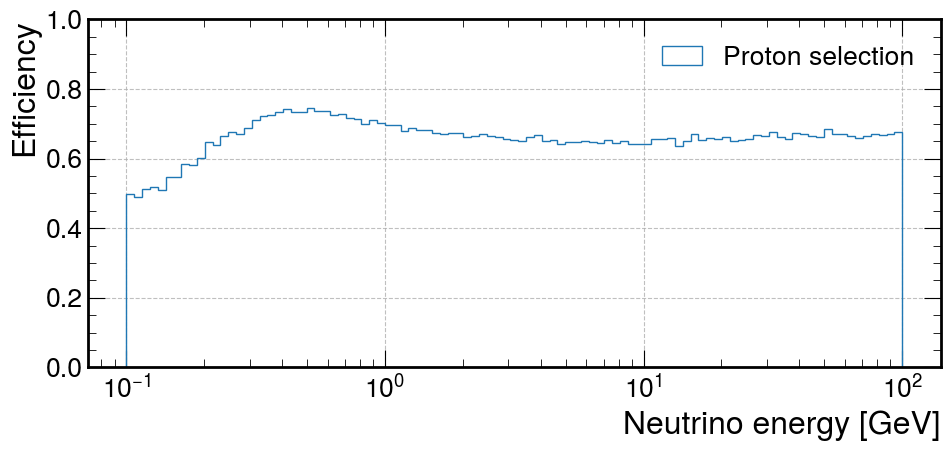

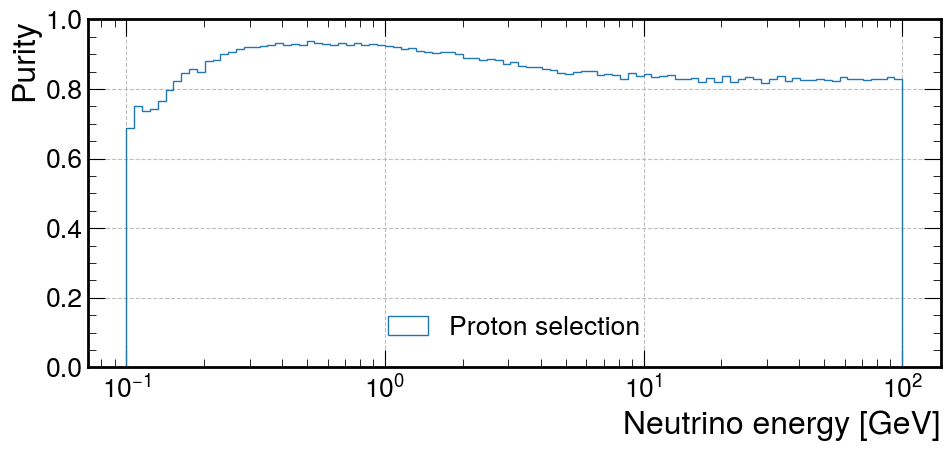

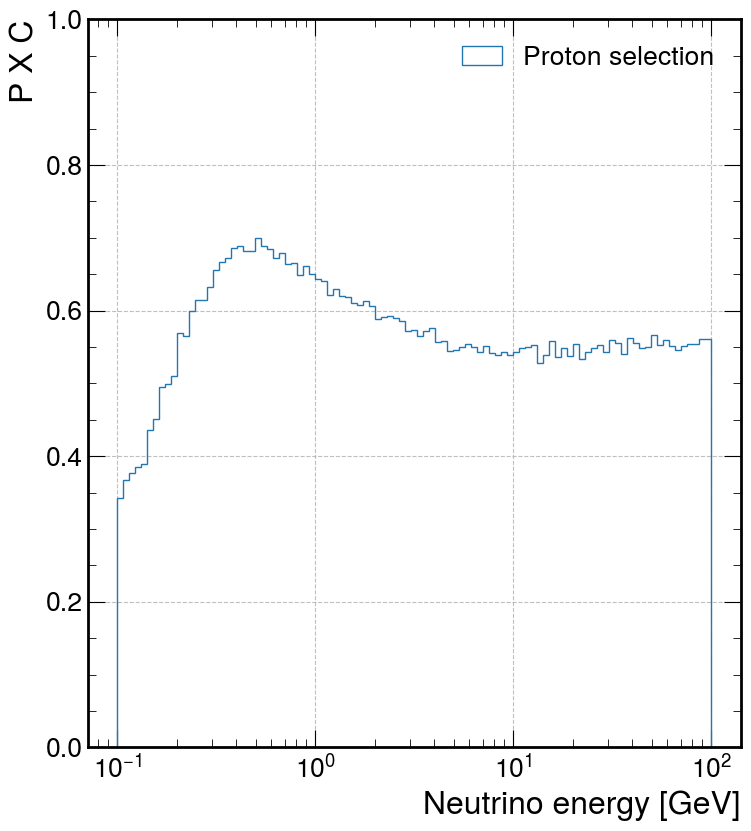

In [15]:
dftest = create_ecandidate(dfall)
dftest = dftest.filter(~pl.col('selected_e')) # removing here for a more precise purity and completeness
# dftestpr = create_proton_candidate(dftest, maxmom=2, maxcalo=1.5)
dftestpr = create_proton_candidate(dftest, return_only_selected=False)
plt.figure()
label='Proton selection'
extra="_nue"
minPnC = 0.
plt.figure(figsize=(10,5))
plot_purity_completeness_particle(dftestpr, type='completeness', label=label, minPnC=minPnC)
plt.ylim(0,1)
plt.xscale('log')
plt.savefig(f'graphs/proton_c{extra}.png', dpi=200)
plt.figure(figsize=(10,5))
plot_purity_completeness_particle(dftestpr, type='purity', label=label, minPnC=minPnC)
plt.ylim(0,1)
plt.xscale('log')
plt.savefig(f'graphs/proton_p{extra}.png', dpi=200)
plt.figure(figsize=(10*0.8,11*0.8))
v, b = plot_purity_completeness_particle(dftestpr, type='pnc', label=label, plotnevents=False, minPnC=minPnC)
plt.xscale('log')
plt.ylim(0,1)
plt.savefig(f'graphs/proton_pnc{extra}.png', dpi=200)

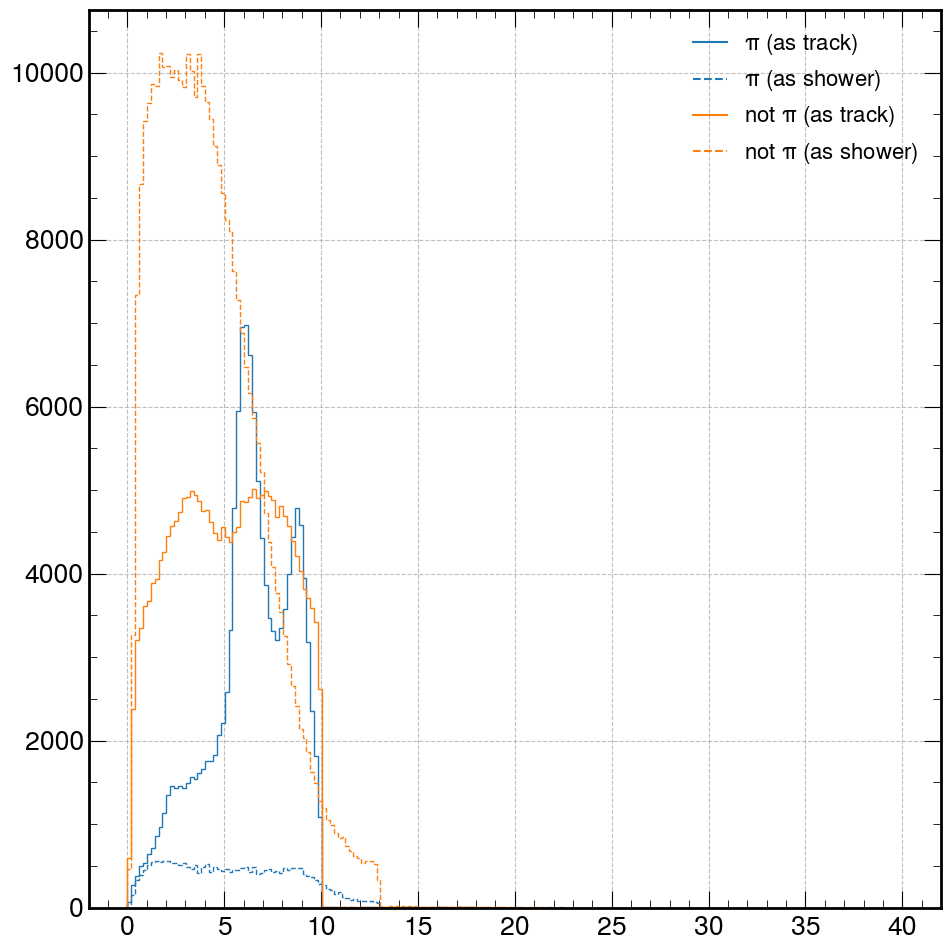

In [16]:
dftestpi = dftestpr.filter(~pl.col('selected_e'), ~pl.col('selected_pr')) # removing here for a more precise purity and completeness

pnccut = 0.
onlycontained=True
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)')
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=211, label=' (as shower)', ls='--', color='C0')
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)', notthispdg=True, color='C1')
plot_pid(dftestpi, 'B', threshold_pnc=pnccut, ShowersAndTracks=True,   onlyShower=True, onlycontained=onlycontained, pdg=211, label=' (as shower)', notthispdg=True, ls="--", color="C1")
# plt.yscale('log')

<Figure size 1000x1000 with 0 Axes>

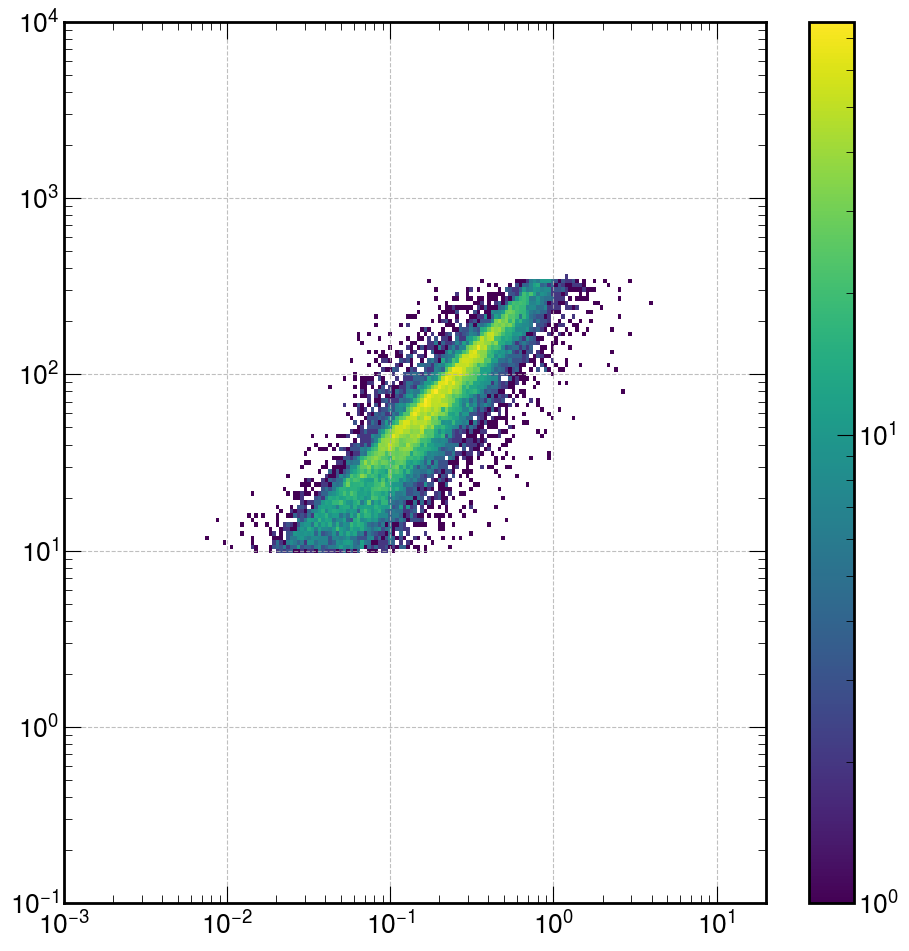

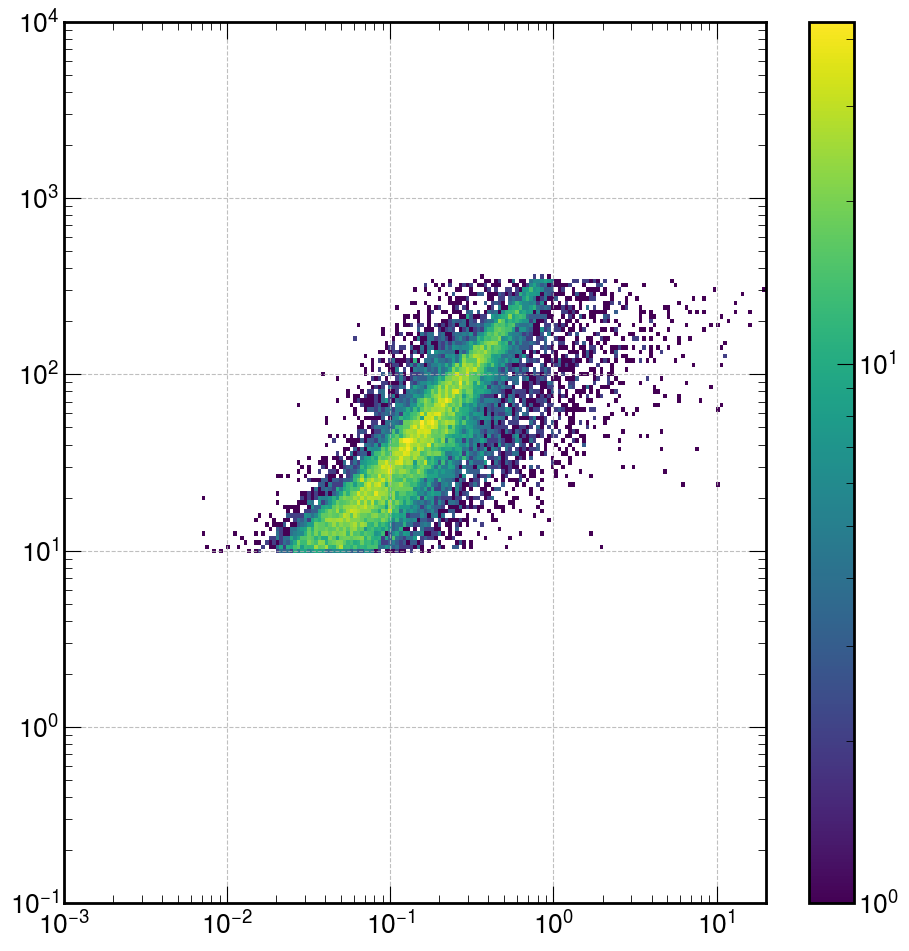

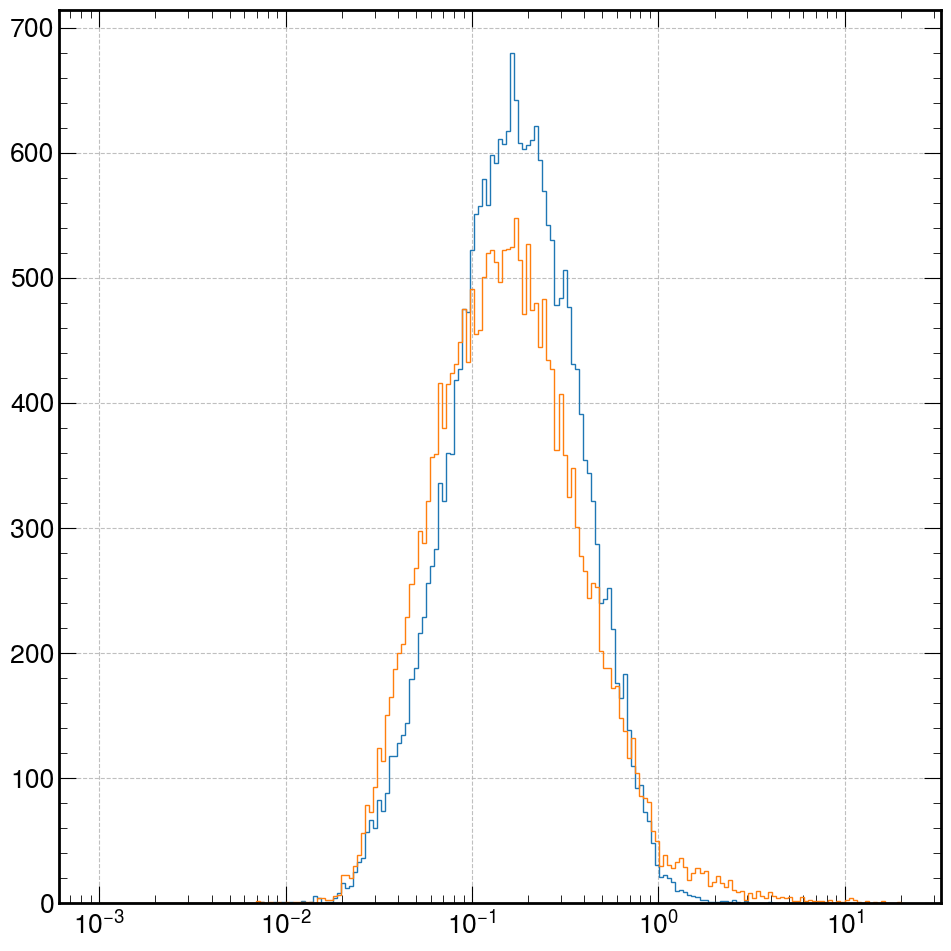

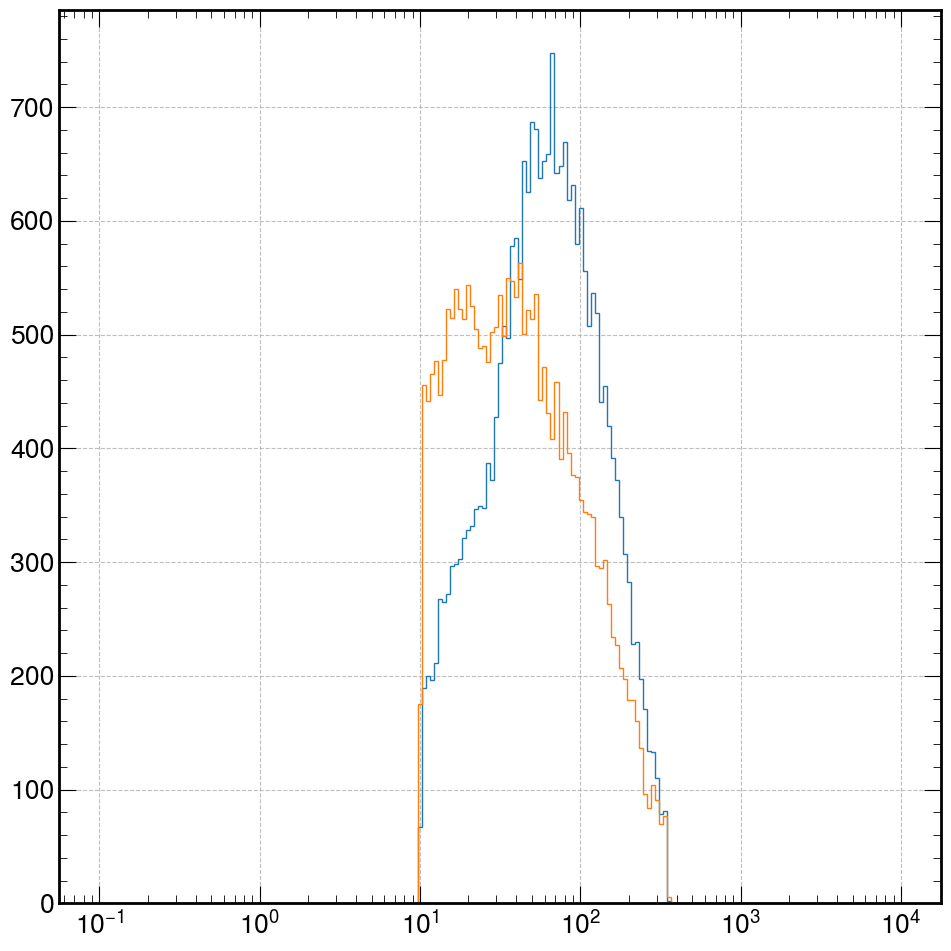

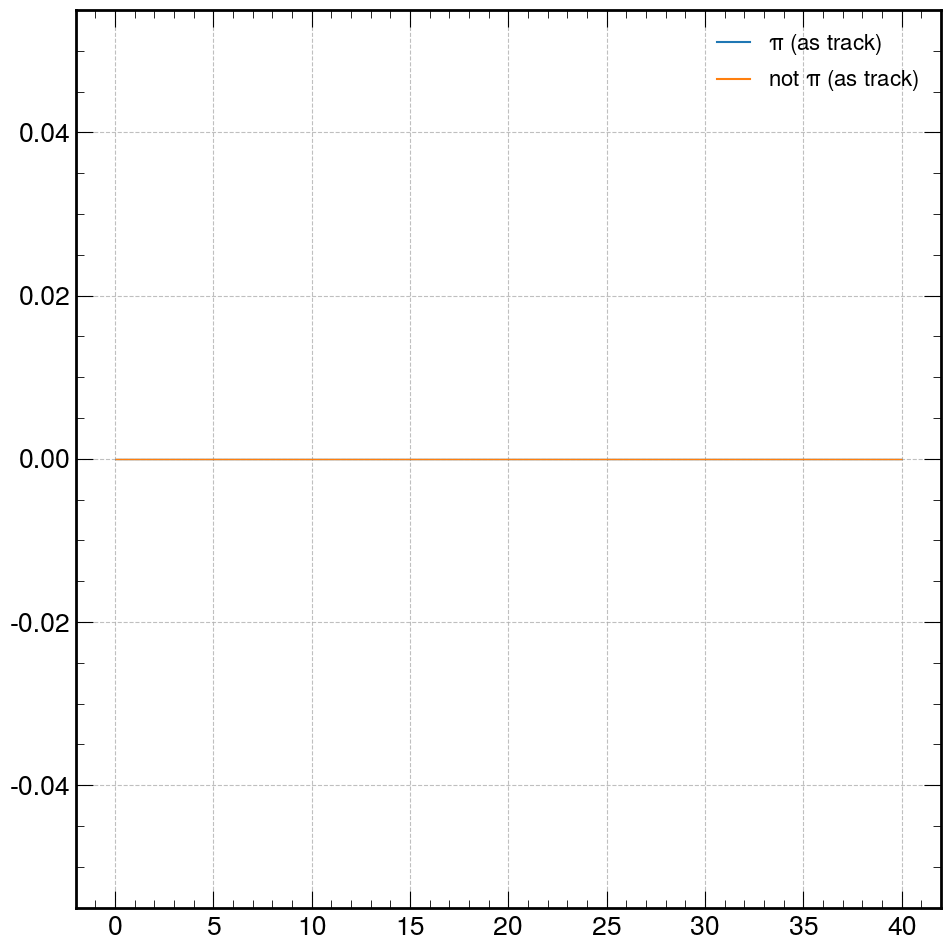

In [17]:
plt.figure()
minPnC=0.
dftest2 = create_pion_candidate(dftestpr, 
                                othercuts=True
                                ).filter(
    True,
    pl.col('pnc')>minPnC,
    ~pl.col('trkIsContained')
).with_columns(
    trkg4mom_planes_B = (pl.col('trkg4en_planes_B')**2 - pl.col('trkg4mass_planes_B')**2).sqrt()
)
vy='trklen'
vx='trkcalo_planes_B'
binscalo = np.linspace(-0.1,15,200)
binscalo = np.logspace(-3,np.log10(20), 200)
binsmomrange = np.logspace(-1, 4, 200)
pdg=211

vmax=None
plt.figure()
plt.hist2d(dftest2.filter(isparticle(pdg)) [vx], dftest2.filter(isparticle(pdg))[vy], bins=[binscalo, binsmomrange], cmin=1, norm='log', vmax=vmax);
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.figure()
plt.hist2d(dftest2.filter(~isparticle(pdg)) [vx], dftest2.filter(~isparticle(pdg))[vy], bins=[binscalo, binsmomrange], cmin=1, norm='log', vmax=vmax);
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

plt.figure()
plt.hist(dftest2.filter(isparticle(pdg)) [vx], bins=binscalo, histtype='step')
plt.hist(dftest2.filter(~isparticle(pdg))[vx], bins=binscalo, histtype='step')
plt.xscale('log')
# plt.yscale('log')
plt.figure()
plt.hist(dftest2.filter(isparticle(pdg)) [vy], bins=binsmomrange, histtype='step')
plt.hist(dftest2.filter(~isparticle(pdg))[vy], bins=binsmomrange, histtype='step')
plt.xscale('log')
# plt.yscale('log')

plt.figure()
plot_pid(dftest2, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)')
plot_pid(dftest2, 'B', threshold_pnc=pnccut, ShowersAndTracks=False, onlyShower=False, onlycontained=onlycontained, pdg=211, label=' (as track)', notthispdg=True, color='C1')

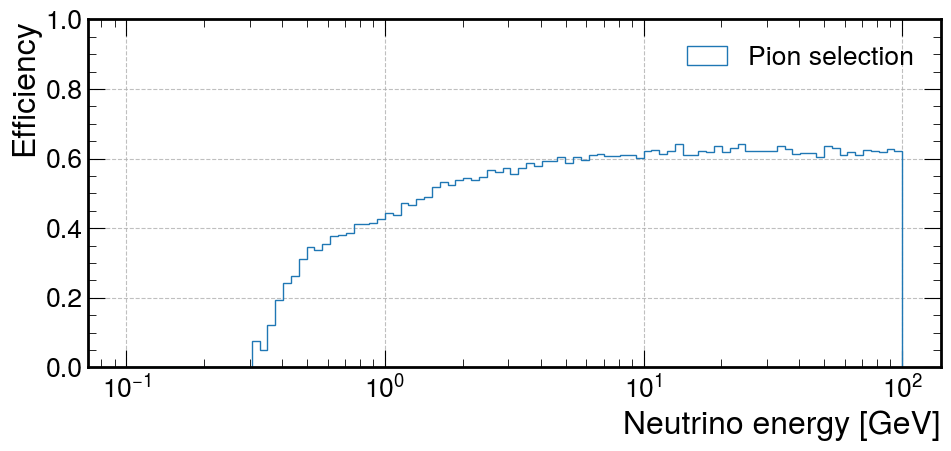

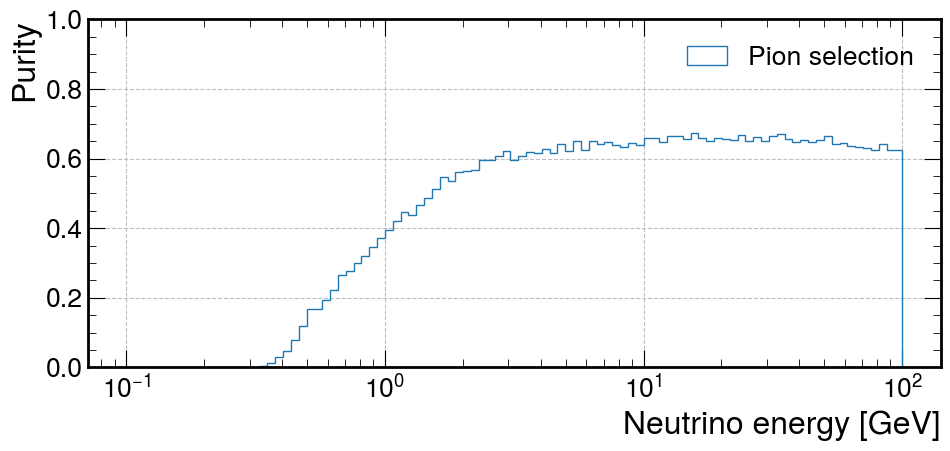

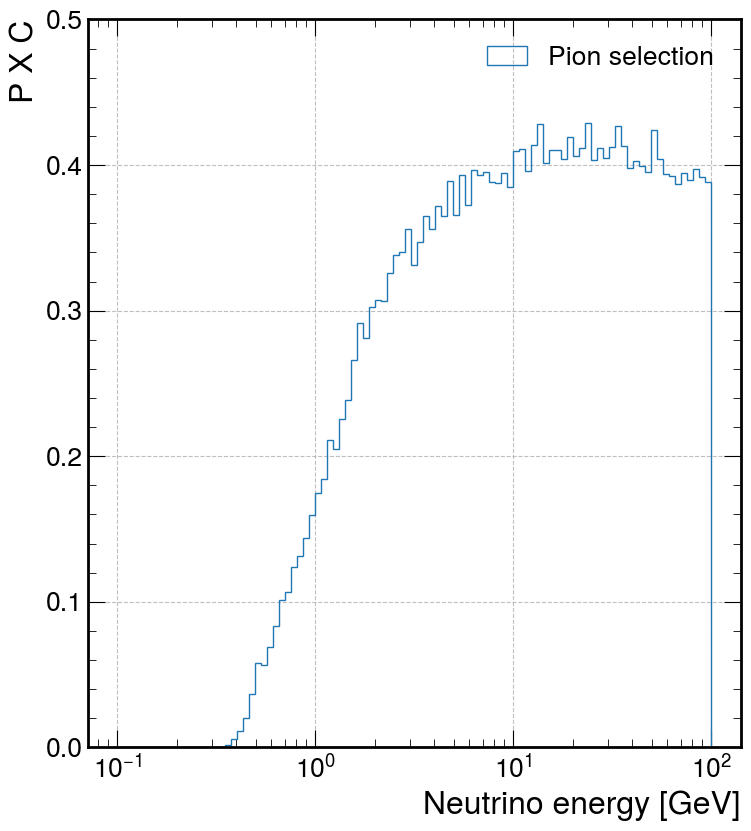

In [18]:
dftest = create_ecandidate(dfall)
dftestpr = create_proton_candidate(dftest, return_only_selected=False)
dfprpiselected = create_pion_candidate(dftestpr, return_only_selected=False, lower_threshold_len=20)
dfmaxeffpi = create_pion_candidate(dftestpr, return_full_efficiency=True, return_only_selected=False)
# dfmaxeffpi = create_pion_candidate(dftestpr, lower_threshold_len=10, return_only_selected=False)
plt.figure(figsize=(10,5))
label='Pion selection'
extra="nue"
minPnC = 0.
pdg=211
dfprpiselected = dfprpiselected.filter(
    ~pl.col('selected_e'),
    ~pl.col('selected_pr'),
#     (isparticle(211)) & (pl.col('rrkIsContained'))
)
plot_purity_completeness_particle(dfprpiselected, type='completeness', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi")
val, b = plot_purity_completeness_particle(dfmaxeffpi, type='completeness', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi", donotplot=True)
# plt.hist(b[:-1], b, weights=val, histtype='step', label='Maximum efficiency');
plt.ylim(0,1)
plt.legend()
plt.xscale('log')
plt.savefig(f'graphs/pion_c{extra}.png', dpi=200)
plt.figure(figsize=(10,5))
plot_purity_completeness_particle(dfprpiselected, type='purity', label=label, minPnC=minPnC, pdg=pdg, selection="selected_pi")
# plot_purity_completeness_particle(dfmaxeffpi, type='purity', label='Maximum efficiency', minPnC=minPnC, pdg=pdg, selection="selected_pi")
plt.xscale('log')
plt.ylim(0,1)
plt.savefig(f'graphs/pion_p{extra}.png', dpi=200)
plt.figure(figsize=(10*0.8,11*0.8))
v, b = plot_purity_completeness_particle(dfprpiselected, type='pnc', label=label, plotnevents=False, minPnC=minPnC, pdg=pdg, selection="selected_pi")
# plot_purity_completeness_particle(dfmaxeffpi, type='pnc', label='Maximum efficiency', minPnC=minPnC, pdg=pdg, selection="selected_pi")
plt.xscale('log')
plt.ylim(0,0.5)
plt.savefig(f'graphs/pion_pnc{extra}.png', dpi=200)

In [29]:
dfe = create_ecandidate(dfall)
dfpr = create_proton_candidate(dfe, return_only_selected=False)
dfprpiselected = create_pion_candidate(dfpr, return_only_selected=False, lower_threshold_len=20)
dfprpiselected_selective = create_pion_candidate(dfpr, return_only_selected=False, lower_threshold_len=10)
dfpr_nopi = dfe.with_columns(
    pl.lit(False).alias('selected_pi'),
    pl.lit(False).alias('selected_pr'),
)
dfcomplex_en = complex_energy_nue(dfprpiselected)
dfcomplex_en_selective = complex_energy_nue(dfprpiselected_selective)
dfcomplex_en_nopi = complex_energy_nue(dfpr_nopi)
dfcomplex_en_full = complex_energy_nue(dfprpiselected, return_full=True)
dfsimple_en = simple_energy_nue(dfall)
dfsimple_en_full = simple_energy_nue(dfall, return_full=True)

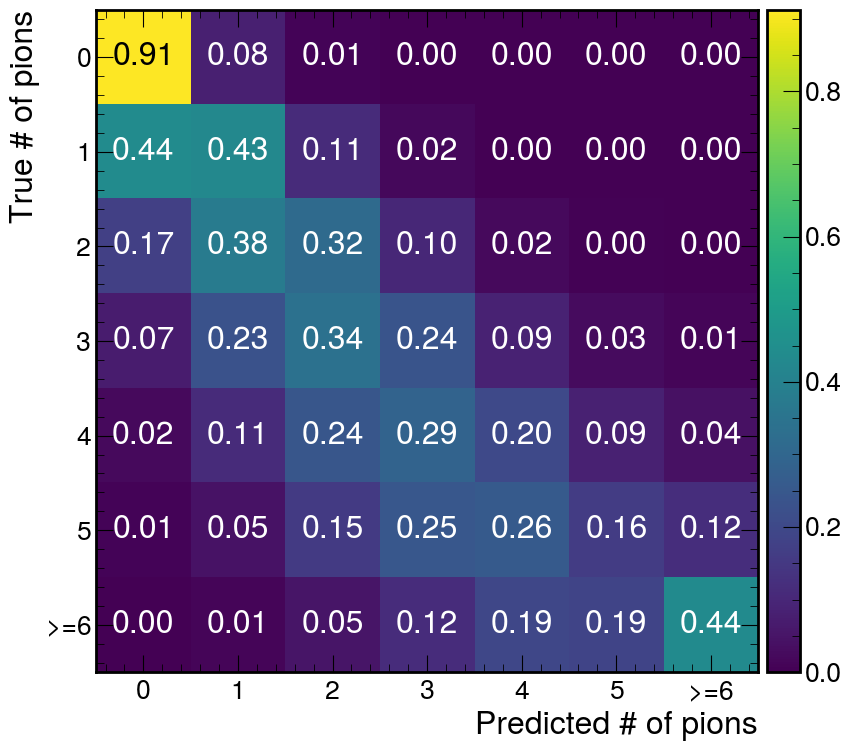

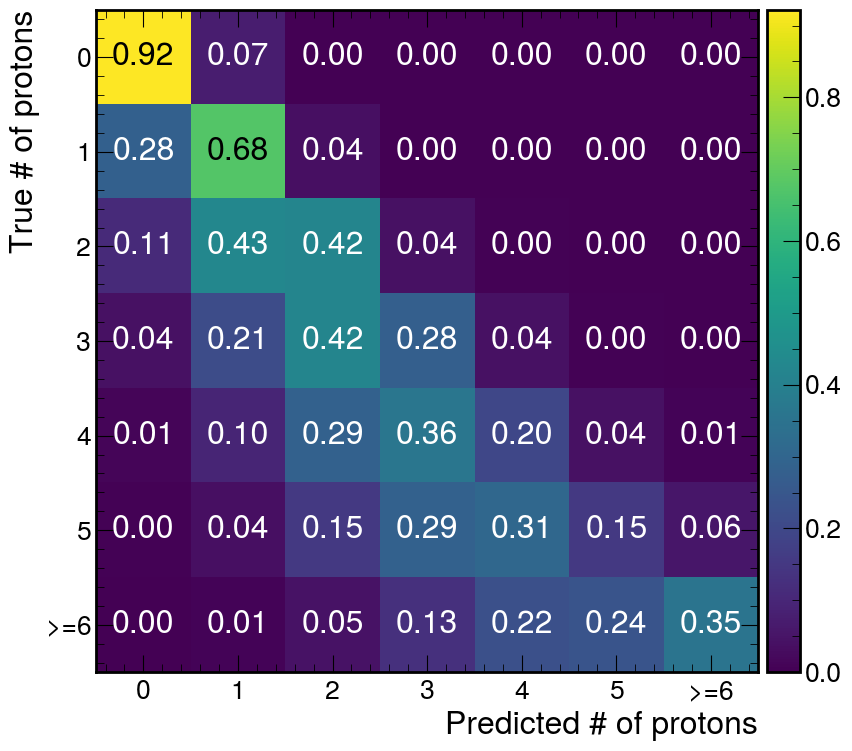

In [30]:

from sklearn import metrics
# dfmatches = dfprpiselected.filter(pl.col('trkPFPIsTrack')).group_by(selection_events(), maintain_order=True).agg(
minPNC=0
dfmatches = dfprpiselected.filter(
        pl.col('pnc') > minPNC
    ).group_by(selection_events(), maintain_order=True).agg(
    pl.col('selected_pi').filter(pl.col('selected_pi')).len().cast(pl.Int32).alias('npi'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(211)).len().cast(pl.Int32).alias('npitruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(211)).unique().len().alias('npitunique'),
    pl.col('selected_pr').filter(pl.col('selected_pr')).len().cast(pl.Int32).alias('npr'),
    pl.col('trkg4pdg_planes_B').filter(isparticle(2212)).len().cast(pl.Int32).alias('nprtruth'),
    pl.col('trkg4id_planes_B').filter(isparticle(2212)).unique().len().alias('nprtunique'),
    pl.col('enu_truth').last(),
    pl.col('lepen').last(),
).with_columns(
    ratio_pi = ( pl.col('npi')-pl.col('npitruth') ),
    ratio_pr = ( pl.col('npr')-pl.col('nprtruth') )
)

nmax=6
classes = [0,1,2,3,4,5,">=6"]
dfmatches = dfmatches.with_columns(
    pl.when(pl.col('npi')>nmax).then(nmax).otherwise(pl.col('npi')).alias('npi'),
    pl.when(pl.col('npitruth')>nmax).then(nmax).otherwise(pl.col('npitruth')).alias('npitruth'),
    pl.when(pl.col('npr')>nmax).then(nmax).otherwise(pl.col('npr')).alias('npr'),
    pl.when(pl.col('nprtruth')>nmax).then(nmax).otherwise(pl.col('nprtruth')).alias('nprtruth'),
)

confusion_matrix_pi = metrics.confusion_matrix(dfmatches['npitruth'], dfmatches['npi'])
# print(confusion_matrix_pi)
# print(confusion_matrix_pi.sum())
confusion_matrix_pi = np.array([ line/total for line, total in zip(confusion_matrix_pi, confusion_matrix_pi.sum(1))])
# print(confusion_matrix_pi)

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pi)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pi[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pi.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pi[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of pions')
plt.xlabel('Predicted # of pions')
plt.show()

confusion_matrix_pr = metrics.confusion_matrix(dfmatches['nprtruth'], dfmatches['npr'])
confusion_matrix_pr = np.array([ line/total for line, total in zip(confusion_matrix_pr, confusion_matrix_pr.sum(1))])

fig, ax = plt.subplots(figsize=(10,8))
cb = ax.imshow(confusion_matrix_pr)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        color='white' if confusion_matrix_pr[i,j] < 0.5 else 'black'
        # color='green' if confusion_matrix_pr.transpose()[j,i] < 0.5 else 'white'
        ax.annotate(f'{confusion_matrix_pr[i,j]:.2f}', (j,i), 
                    color=color, va='center', ha='center')
ax.grid(False)
plt.colorbar(cb, ax=ax, pad=0.01)
plt.ylabel('True # of protons')
plt.xlabel('Predicted # of protons')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


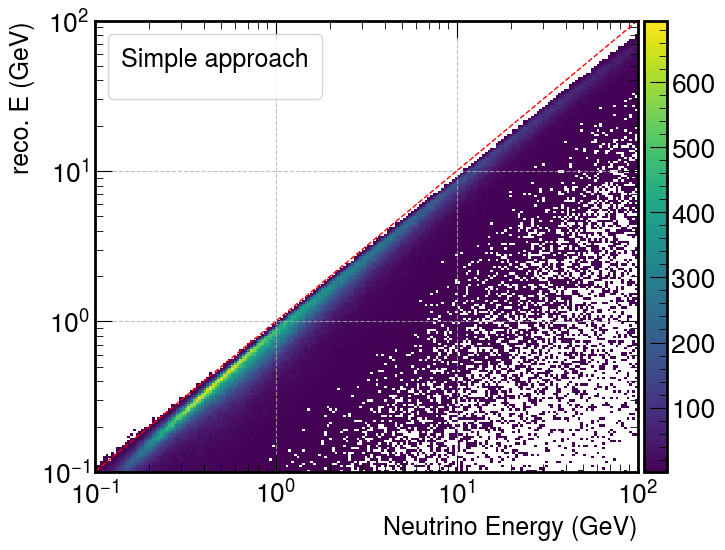

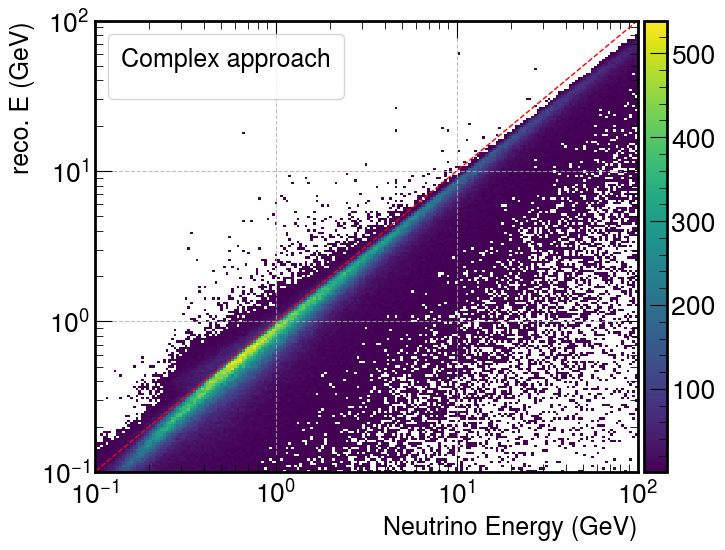

In [31]:
def plot_en_vs_en(Emu:pl.DataFrame,
                  lmethod,
                  x='enu_truth',
                  y='Etotal',
                  figsize=(8,6),
                  binsx=None,
                  binsy=None,
                  zscale='linear'
                  ):

    fig = plt.figure(figsize=figsize)
    if binsx is None:
        binsx = np.logspace(-1,2,200)
    if binsy is None:
        binsy = np.logspace(-1,2,200)
    # binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize=18
    # fontsize='xx-large'
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm=zscale, cmin=1, rasterized=True);
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Neutrino Energy (GeV)', fontsize=fontsize)
    plt.ylabel(f'reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    # plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    # cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    if lmethod != '':
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
        plt.setp(legend.get_title(),fontsize=fontsize)
    plt.plot([0,100],[0,100], 'r--', lw=1)
    # dunestyle.Preliminary(x=0.45, y=0.93, ax=plt.gca(), fontsize="xx-large")


binse=None
# binse=np.logspace(np.log10(50),2,100)
binsereco = binse
# binsereco = np.logspace(-1,2,100)
plot_en_vs_en(dfsimple_en, binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plot_en_vs_en(dfcomplex_en, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
# plot_en_vs_en(dfcomplex_en_2, binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


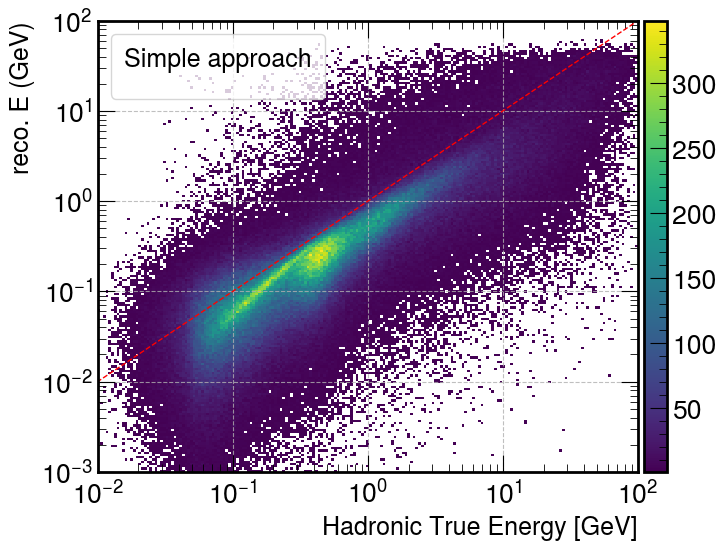

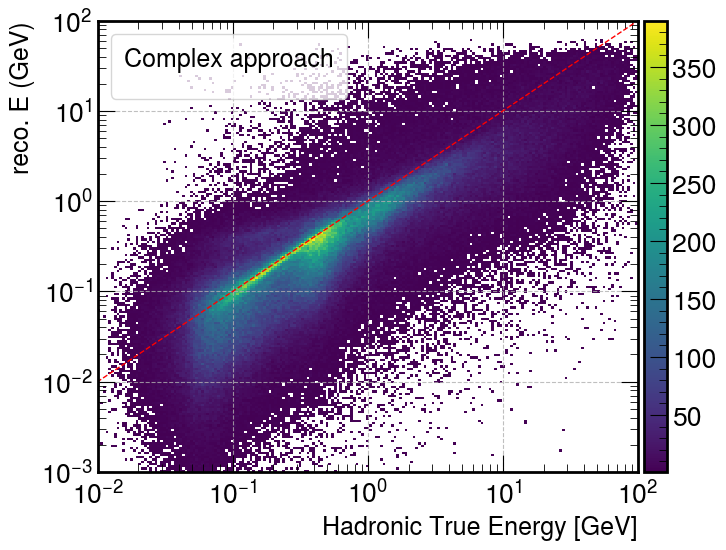

<Figure size 1000x1000 with 0 Axes>

In [34]:
binse=None
binse=np.logspace(-2,2,200)
binsereco = binse
binsereco=np.logspace(-3,2,200)
# binsereco = np.logspace(-1,2,100)
plot_en_vs_en(dfsimple_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')
plot_en_vs_en(dfcomplex_en, x='had_truth', y='Ehad', binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale='linear')
plt.xlabel('Hadronic True Energy [GeV]')
plt.figure()
binse=np.logspace(-1.05,2,100)
binsereco = binse
# binsereco = np.logspace(-1,2,100)
# zscale='linear'
# plot_en_vs_en(dfsimple_en, x='lepen', y='Elep', binsy=binsereco, binsx=binse, lmethod='Simple approach', zscale=zscale)
# plt.xlabel('Muon True Energy [GeV]')
# plot_en_vs_en(dfcomplex_en, x='lepen', y='Elep', binsy=binsereco, binsx=binse, lmethod='Complex approach', zscale=zscale)
# plt.xlabel('Muon True Energy [GeV]')

In [35]:
from scipy.stats import binned_statistic
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'Neutrino Energy [GeV]',
                    ylabel = '',
                    makefrac = True,
                    fmt='.',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    xpre = 0.3,
                    ypre = 0.93,
                    # titlesize='xx-large',
                    titlesize=None,
                    legendsize=None,
                    nolegend=False,
                    **kwargs):
    x = x.filter(y>0)
    y = y.filter(y>0)
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Resolution [%]'
        # if title=='':
        #     title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$E_{reco}/E_{true}-1$'
        # if title=='':
        #     title = 'Mean'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if not nolegend:
        legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, title_fontsize=titlesize, fontsize=legendsize)
        legend.get_frame().set_edgecolor('k')
        legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    # dunestyle.Preliminary(x=xpre, y=ypre, ax=plt.gca(), fontsize="xx-large")

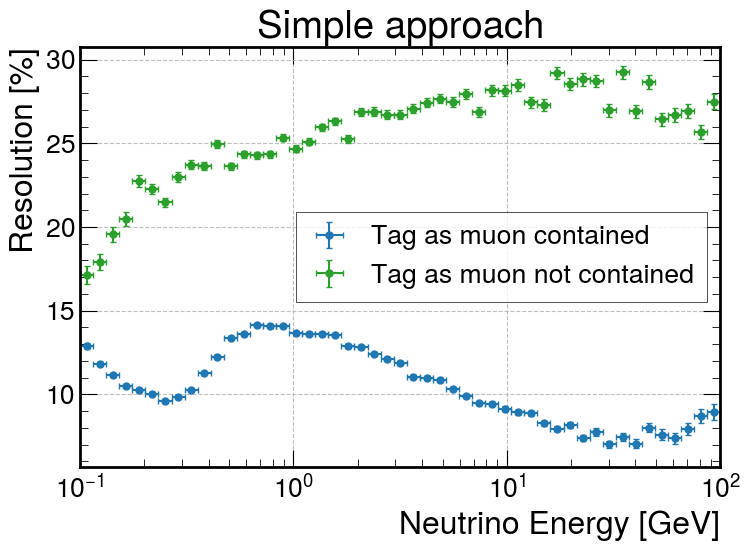

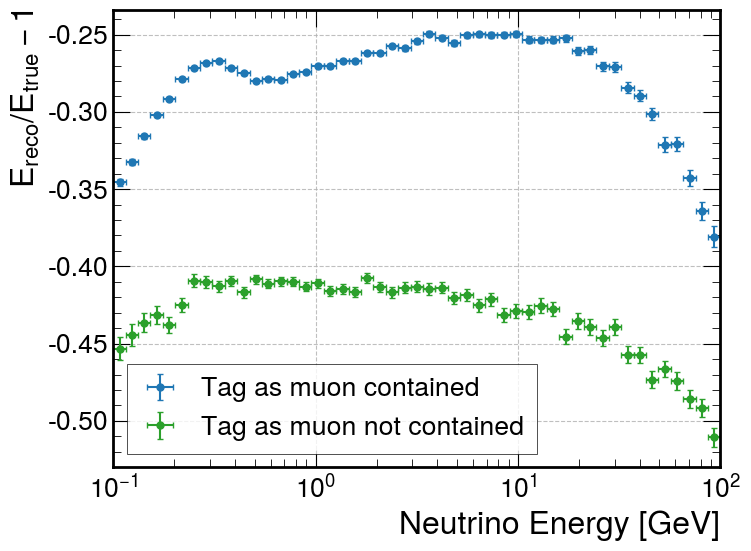

In [36]:

binsx= np.logspace(-1,2,50)
xscale='log'
capsize=2
label='LLHD'
plt.figure(figsize=(8,6))
x='lepmom'
y='Pe'
x='enu_truth'
y='Etotal'
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon contained",
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon not contained",
    color='C2'
)
# plt.savefig('graphs/simple_res.png')
# plt.ylim(0,60)
plt.title('Simple approach')

plt.figure(figsize=(8,6))
plot_res_scatter(
    dfsimple_en.filter(pl.col('trkIsContained'))[x],
    dfsimple_en.filter(pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon contained",
    infotype='mean',
)
plot_res_scatter(
    dfsimple_en.filter(~pl.col('trkIsContained'))[x],
    dfsimple_en.filter(~pl.col('trkIsContained'))[y],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Tag as muon not contained",
    infotype='mean',
    color='C2'
)

# plt.savefig('graphs/simple_bias.png')

In [37]:

def the_res_scatter(labels = None, infotype="std", *args, **kargs):
    commonargs = dict(
        binsx= np.logspace(-1,2,50),
        xscale='log',
        legendsize=16,
        titlesize=20,
        colorscontained=['C0','C1'],
        colorsnotcontained=['C2','C3'],
    )
    for k in commonargs.keys():
        if k not in kargs.keys():
            kargs[k] = commonargs[k]
    
    x='enu_truth'
    y='Etotal'
    if 'x' in kargs.keys():
        x=kargs.pop('x')
    if 'y' in kargs.keys():
        y=kargs.pop('y')
    if labels is None:
        labels = [ i for i, _ in enumerate(args)]
    figsize = kargs.pop('figsize',(8,6))
    plts = []
    plts.append(plt.figure(figsize=figsize))
    thecolors_c = kargs.pop('colorscontained')
    thecolors_nc = kargs.pop('colorsnotcontained')
    if kargs.pop("no_color", False):
        thecolors_c = [ None for _ in labels ]
        thecolors_nc = [ None for _ in labels ]
    separated = kargs.pop("separated", False)
    nolegend = kargs.pop("nolegend", False)
    for df, label, c in zip(args, labels, thecolors_c):
        tlabel = f"{label} - Contained"
        title=''
        if separated:
            tlabel = label
            title = 'Contained'
        plot_res_scatter(
            df.filter(pl.col('trkIsContained'))[x],
            df.filter(pl.col('trkIsContained'))[y],
            label=tlabel,
            infotype=infotype,
            color=c,
            title=title,
            nolegend=nolegend,
            **kargs,
        )
    if separated:
        plts.append(plt.figure(figsize=figsize))
    for df, label, c in zip(args, labels, thecolors_nc):
        tlabel = f"{label} - Not contained"
        title=''
        if separated:
            tlabel = label
            title = 'Not contained'
        plot_res_scatter(
            df.filter(~pl.col('trkIsContained'))[x],
            df.filter(~pl.col('trkIsContained'))[y],
            label=tlabel,
            infotype=infotype,
            color=c,
            title=title,
            nolegend=nolegend,
            **kargs,
        )
    return plts



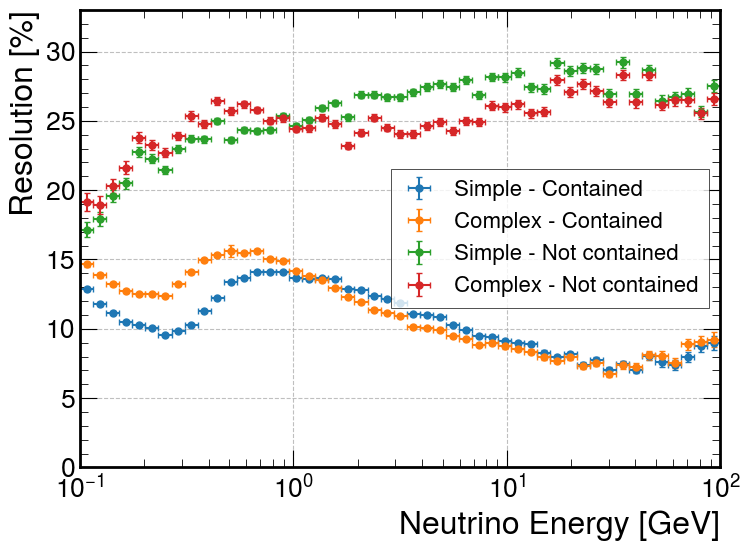

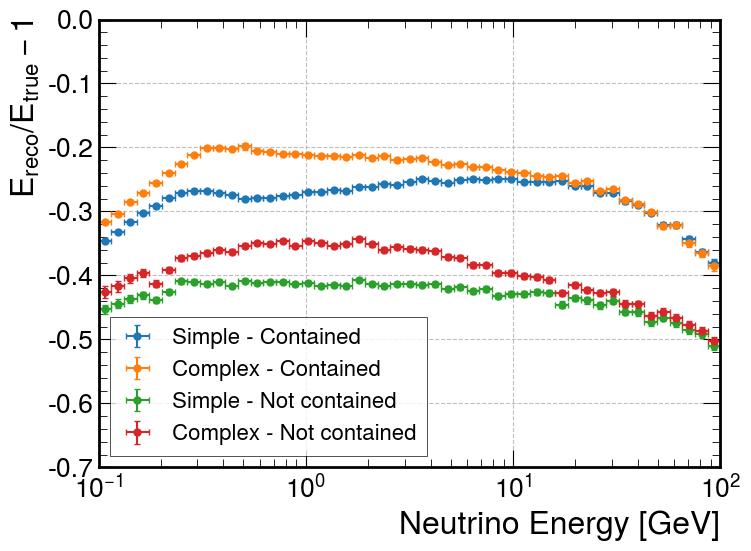

In [39]:
commonargs = dict(
    binsx= np.logspace(-1,2,50),
    xscale='log',
    capsize=2,
)
extra=""
the_res_scatter(["Simple","Complex"], "std", dfsimple_en, dfcomplex_en, **commonargs)
plt.ylim(0,33)
plt.savefig(f'graphs/nue/nue_res{extra}.png')
the_res_scatter(["Simple","Complex"], "mean", dfsimple_en, dfcomplex_en, **commonargs)
plt.ylim(-0.7,0)
plt.savefig(f'graphs/nue/nue_bias{extra}.png')

In [102]:
dfsimple = 0
dfsimple_en = 0
dfe = 0
dfprselected = 0
dfprpiselected = 0
dfcomplex_en = 0
def process_data(dfall:pl.DataFrame, cheatlep = False, cheatpi = False, cheatpr = False, minPNC=0.0, saveit=True):
    global dfsimple
    global dfsimple_en
    global dfe
    global dfprselected
    global dfprpiselected
    global dfcomplex_en
    dfsimple = create_ecandidate(dfall, clear_low_en_as_shower=False, filter_protons=False)
    dfsimple_en = simple_energy_nue(dfsimple)
    dfe = create_ecandidate(dfall, cheat=cheatlep)
    dfprselected = create_proton_candidate(dfe, cheat=cheatpi, cheatMinPNC=minPNC, return_only_selected=False)
    dfprpiselected = create_pion_candidate(dfprselected, cheat=cheatpr, cheatMinPNC=minPNC, lower_threshold_len=20, return_only_selected=False)
    dfcomplex_en = complex_energy_nue(dfprpiselected, W="W")
    if not saveit:
        return

    dfsimple_en.select(
        dfcomplex_en.drop('Kpi', 'Kpr', 'OtherPFPs', 'mass_to_add').columns
    ).write_parquet("./data/processed/nue/simple.parquet")
    complexname = "complex"
    if cheatlep or cheatpi or cheatpr:
        complexname+="_cheat"
    if cheatlep:
        complexname+="_e"
    if cheatpi:
        complexname+="_pi"
    if cheatpr:
        complexname+="_pr"
    dfcomplex_en.write_parquet(f"./data/processed/nue/{complexname}.parquet")
    complexname

minPNC=0.
# process_data(dfall, cheatlep=True, cheatpi=True, cheatpr=True, saveit=False, minPNC=minPNC)
from itertools import product
possibles = [True, False]
res = product(possibles, repeat=3)
for docheats in res:
    c_lep = docheats[0]
    c_pi = docheats[1]
    c_pr = docheats[2]
    process_data(dfall, cheatlep=c_lep, cheatpi=c_pi, cheatpr=c_pr, minPNC=minPNC )